# Experiment 3: Hinting Effect Analysis
## Does revealing model identities change judge behavior?

**Current Analysis: Group 2 (Competitors)**
- Judges see competitor models revealed, but their own model is "Not disclosed"
- This allows us to test if knowing competitors affects self-bias

**Available Groups:**
- **Group 2 (Competitors)**: ✅ Available
- **Group 4 (Blind)**: ✅ Available (baseline for comparison)


In [7]:
import sys
sys.path.insert(0, '../../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from scipy import stats

from analysis import (
    load_and_merge_data,
    calculate_top1_preference,
    calculate_average_scores,
    calculate_category_preference,
    calculate_tier_preference,
    detect_self_bias,
    run_statistical_tests
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Imports successful")


✓ Imports successful


## 1. Load Data

Load Group 2 (Competitors) judgments and optionally Group 4 (Blind baseline) for comparison.


In [9]:
# Paths
ANSWERS_PATH = "data/answers/answers_mt_bench.json"  # Symlink to exp2 answers
JUDGMENTS_DIR = Path("data/judgments")

# Group files to load (add more as they become available)
GROUP_FILES = {
    "group2_competitors": "judgments_group2.json",
    "group4_blind": "judgments_group4.json",  # Baseline for comparison
}

print("Loading answers...")
with open(ANSWERS_PATH, 'r') as f:
    answers = json.load(f)
print(f"✓ Loaded {len(answers)} answers")

# Load available groups
groups_data = {}
for group_name, filename in GROUP_FILES.items():
    filepath = JUDGMENTS_DIR / filename
    if filepath.exists():
        with open(filepath, 'r') as f:
            judgments = json.load(f)
        groups_data[group_name] = judgments
        print(f"✓ {group_name}: {len(judgments)} judgments")
    else:
        print(f"⚠ {group_name}: File not found ({filepath})")

print(f"\nLoaded {len(groups_data)} group(s)")
if 'group4_blind' in groups_data:
    print("  → Will compare Group 2 to baseline (Group 4)")


Loading answers...
✓ Loaded 480 answers
✓ group2_competitors: 480 judgments
✓ group4_blind: 480 judgments

Loaded 2 group(s)
  → Will compare Group 2 to baseline (Group 4)


In [10]:
# Merge each group with answers and add hint_group column
def merge_with_hint_group(judgments, answers, hint_group):
    rows = []
    for judgment in judgments:
        if 'error' in judgment:
            continue
        
        prompt_id = judgment['prompt_id']
        judge = judgment['judge_model']
        ranking = judgment['ranking']
        scores = judgment['scores']
        mapping = judgment['mapping']
        
        for rank_idx, label in enumerate(ranking):
            answer_id = mapping[label]
            score = scores[label]
            
            answer = next((a for a in answers if a['answer_id'] == answer_id), None)
            if answer is None:
                continue
            
            rows.append({
                'prompt_id': prompt_id,
                'category': answer['category'],
                'answer_id': answer_id,
                'model_vendor': answer['model_vendor'],
                'model_tier': answer['model_tier'],
                'judge': judge,
                'hint_group': hint_group,
                'rank': rank_idx + 1,
                'score': score,
                'is_top_ranked': rank_idx == 0
            })
    
    return pd.DataFrame(rows)

# Create combined dataframe
dfs = []
for group_name, judgments in groups_data.items():
    df = merge_with_hint_group(judgments, answers, group_name)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print(f"✓ Combined dataset: {len(df_all)} records")
print(f"  Unique prompts: {df_all['prompt_id'].nunique()}")
print(f"  Judges: {sorted(df_all['judge'].unique())}")
print(f"  Hint groups: {sorted(df_all['hint_group'].unique())}")
print(f"\nRecords per group:")
print(df_all.groupby('hint_group').size())

display(df_all.head())


✓ Combined dataset: 5759 records
  Unique prompts: 80
  Judges: ['claude_fast', 'claude_thinking', 'gemini_fast', 'gemini_thinking', 'gpt_fast', 'gpt_thinking']
  Hint groups: ['group2_competitors', 'group4_blind']

Records per group:
hint_group
group2_competitors    2880
group4_blind          2879
dtype: int64


,prompt_id,category,answer_id,model_vendor,model_tier,judge,hint_group,rank,score,is_top_ranked
0,writing_081,writing,ans_writing_081_gpt_thinking,gpt,thinking,gpt_fast,group2_competitors,1,10,True
1,writing_081,writing,ans_writing_081_claude_fast,claude,fast,gpt_fast,group2_competitors,2,9,False
2,writing_081,writing,ans_writing_081_claude_thinking,claude,thinking,gpt_fast,group2_competitors,3,8,False
3,writing_081,writing,ans_writing_081_gpt_fast,gpt,fast,gpt_fast,group2_competitors,4,7,False
4,writing_081,writing,ans_writing_081_gemini_fast,gemini,fast,gpt_fast,group2_competitors,5,6,False


## 2. Self-Bias Analysis for Group 2 (Competitors)

Analyze self-bias when judges see competitor models but not their own.


In [11]:
def calculate_self_bias_by_group(df, vendor='gpt'):
    """Calculate self-bias for each vendor across hint groups"""
    results = []
    
    for hint_group in sorted(df['hint_group'].unique()):
        group_df = df[df['hint_group'] == hint_group]
        
        for judge in sorted(group_df['judge'].unique()):
            judge_df = group_df[group_df['judge'] == judge]
            top1 = judge_df[judge_df['is_top_ranked'] == True]
            
            # Check if this judge is from the target vendor
            judge_vendor = judge.split('_')[0]
            is_own_judge = judge_vendor == vendor
            
            vendor_top1 = len(top1[top1['model_vendor'] == vendor])
            total = len(top1)
            rate = vendor_top1 / total if total > 0 else 0
            
            results.append({
                'hint_group': hint_group,
                'judge': judge,
                'vendor': vendor,
                'is_own_judge': is_own_judge,
                'top1_rate': rate,
                'top1_count': vendor_top1,
                'total': total
            })
    
    return pd.DataFrame(results)

# Calculate for all vendors
self_bias_results = {}
for vendor in ['claude', 'gpt', 'gemini']:
    self_bias_results[vendor] = calculate_self_bias_by_group(df_all, vendor)

# Display self-bias for Group 2
print("Self-Bias in Group 2 (Competitors):")
print("=" * 70)
for vendor in ['claude', 'gpt', 'gemini']:
    vendor_bias = self_bias_results[vendor]
    vendor_own = vendor_bias[(vendor_bias['is_own_judge'] == True) & 
                             (vendor_bias['hint_group'] == 'group2_competitors')]
    if len(vendor_own) > 0:
        avg_rate = vendor_own['top1_rate'].mean() * 100
        print(f"\n{vendor.upper()}:")
        print(vendor_own[['judge', 'top1_rate', 'top1_count', 'total']].to_string(index=False))
        print(f"  Average self-preference: {avg_rate:.1f}%")


Self-Bias in Group 2 (Competitors):

CLAUDE:
          judge  top1_rate  top1_count  total
    claude_fast      0.325          26     80
claude_thinking      0.400          32     80
  Average self-preference: 36.3%

GPT:
       judge  top1_rate  top1_count  total
    gpt_fast     0.5875          47     80
gpt_thinking     0.7250          58     80
  Average self-preference: 65.6%

GEMINI:
          judge  top1_rate  top1_count  total
    gemini_fast     0.3000          24     80
gemini_thinking     0.2625          21     80
  Average self-preference: 28.1%


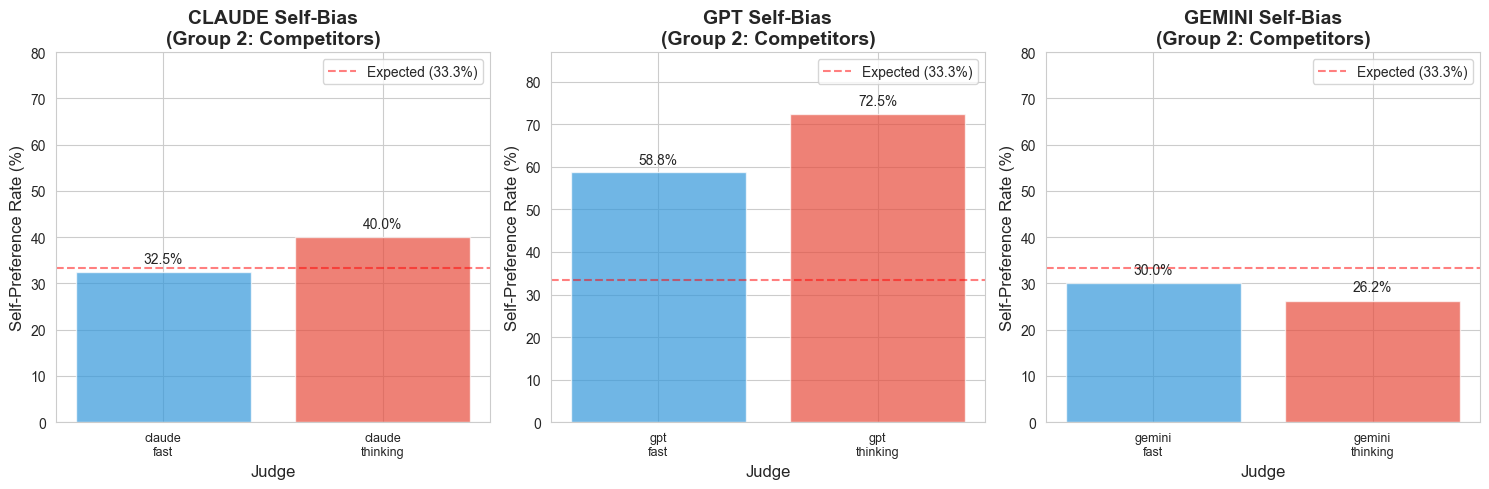

In [12]:
# Visualize self-bias for Group 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, vendor in enumerate(['claude', 'gpt', 'gemini']):
    ax = axes[idx]
    vendor_bias = self_bias_results[vendor]
    vendor_own = vendor_bias[(vendor_bias['is_own_judge'] == True) & 
                             (vendor_bias['hint_group'] == 'group2_competitors')]
    
    if len(vendor_own) > 0:
        judges = vendor_own['judge'].values
        rates = vendor_own['top1_rate'].values * 100
        
        bars = ax.bar(range(len(judges)), rates, alpha=0.7, 
                     color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(judges)])
        
        ax.set_title(f'{vendor.upper()} Self-Bias\n(Group 2: Competitors)', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Judge', fontsize=12)
        ax.set_ylabel('Self-Preference Rate (%)', fontsize=12)
        ax.set_xticks(range(len(judges)))
        ax.set_xticklabels([j.replace('_', '\n') for j in judges], fontsize=9)
        ax.axhline(y=33.33, color='red', linestyle='--', alpha=0.5, label='Expected (33.3%)')
        ax.legend()
        ax.set_ylim([0, max(80, rates.max() * 1.2)])
        
        # Add value labels
        for i, rate in enumerate(rates):
            ax.text(i, rate + 2, f'{rate:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('data/results/self_bias_group2.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Comparison to Blind Baseline (Group 4)

Compare Group 2 (Competitors) to Group 4 (Blind) baseline if available.


Self-Bias: Group 2 (Competitors) vs Group 4 (Blind)
vendor  baseline_rate  group2_rate  change_pp
claude         30.000       36.250       6.25
   gpt         64.375       65.625       1.25
gemini         33.125       28.125      -5.00


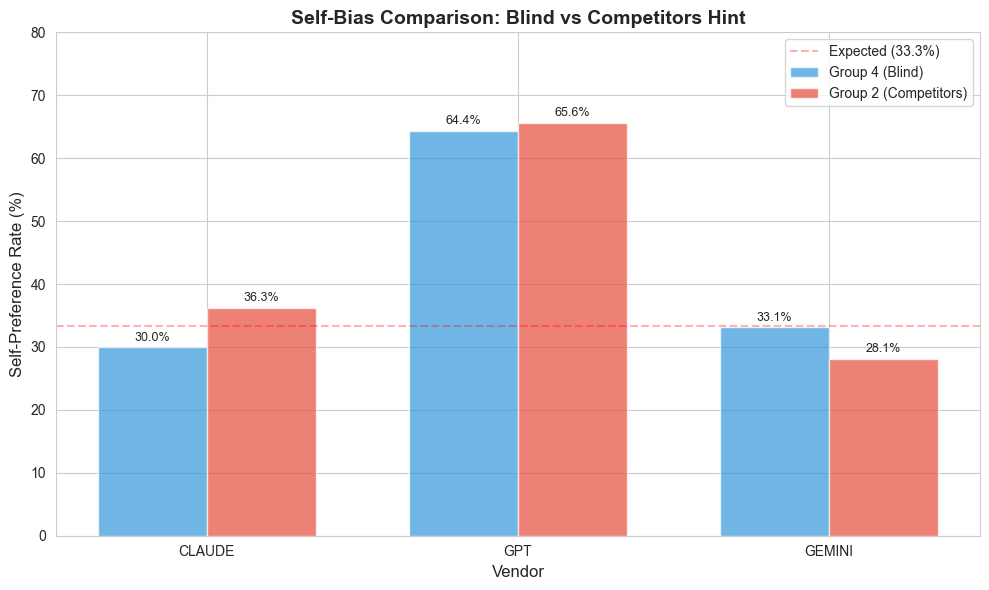


Change from Baseline (percentage points):
  CLAUDE: +6.2 pp
  GPT: +1.2 pp
  GEMINI: -5.0 pp


In [13]:
# Compare Group 2 to baseline if available
if 'group4_blind' in df_all['hint_group'].unique():
    def calculate_bias_change(df, baseline_group='group4_blind', target_group='group2_competitors'):
        """Compare self-bias in target group to baseline"""
        results = []
        
        for vendor in ['claude', 'gpt', 'gemini']:
            vendor_bias = calculate_self_bias_by_group(df, vendor)
            vendor_own = vendor_bias[vendor_bias['is_own_judge'] == True]
            
            # Get baseline (average across judges of same vendor)
            baseline = vendor_own[vendor_own['hint_group'] == baseline_group]
            baseline_rate = baseline['top1_rate'].mean() if len(baseline) > 0 else 0
            
            # Get target group
            target = vendor_own[vendor_own['hint_group'] == target_group]
            target_rate = target['top1_rate'].mean() if len(target) > 0 else 0
            
            change = (target_rate - baseline_rate) * 100  # percentage points
            
            results.append({
                'vendor': vendor,
                'baseline_rate': baseline_rate * 100,
                'group2_rate': target_rate * 100,
                'change_pp': change
            })
        
        return pd.DataFrame(results)
    
    bias_changes = calculate_bias_change(df_all)
    print("Self-Bias: Group 2 (Competitors) vs Group 4 (Blind)")
    print("=" * 70)
    print(bias_changes.to_string(index=False))
    
    # Visualize comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(bias_changes))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, bias_changes['baseline_rate'], width, 
                   label='Group 4 (Blind)', alpha=0.7, color='#3498db')
    bars2 = ax.bar(x + width/2, bias_changes['group2_rate'], width,
                   label='Group 2 (Competitors)', alpha=0.7, color='#e74c3c')
    
    ax.set_xlabel('Vendor', fontsize=12)
    ax.set_ylabel('Self-Preference Rate (%)', fontsize=12)
    ax.set_title('Self-Bias Comparison: Blind vs Competitors Hint', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(bias_changes['vendor'].str.upper())
    ax.axhline(y=33.33, color='red', linestyle='--', alpha=0.3, label='Expected (33.3%)')
    ax.legend()
    ax.set_ylim([0, max(80, bias_changes[['baseline_rate', 'group2_rate']].max().max() * 1.2)])
    
    # Add value labels
    for i, (baseline, group2) in enumerate(zip(bias_changes['baseline_rate'], bias_changes['group2_rate'])):
        ax.text(i - width/2, baseline + 1, f'{baseline:.1f}%', ha='center', fontsize=9)
        ax.text(i + width/2, group2 + 1, f'{group2:.1f}%', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('data/results/bias_comparison_group2_vs_baseline.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Show change in percentage points
    print("\nChange from Baseline (percentage points):")
    for _, row in bias_changes.iterrows():
        change_str = f"+{row['change_pp']:.1f}" if row['change_pp'] >= 0 else f"{row['change_pp']:.1f}"
        print(f"  {row['vendor'].upper()}: {change_str} pp")
else:
    print("⚠ Group 4 (Blind) baseline not available for comparison.")
    print("  Run with group4_blind.json to enable baseline comparison.")


## 4. Cross-Judge Comparison for Group 2

Compare how different judges rank each vendor in the competitors hint condition.


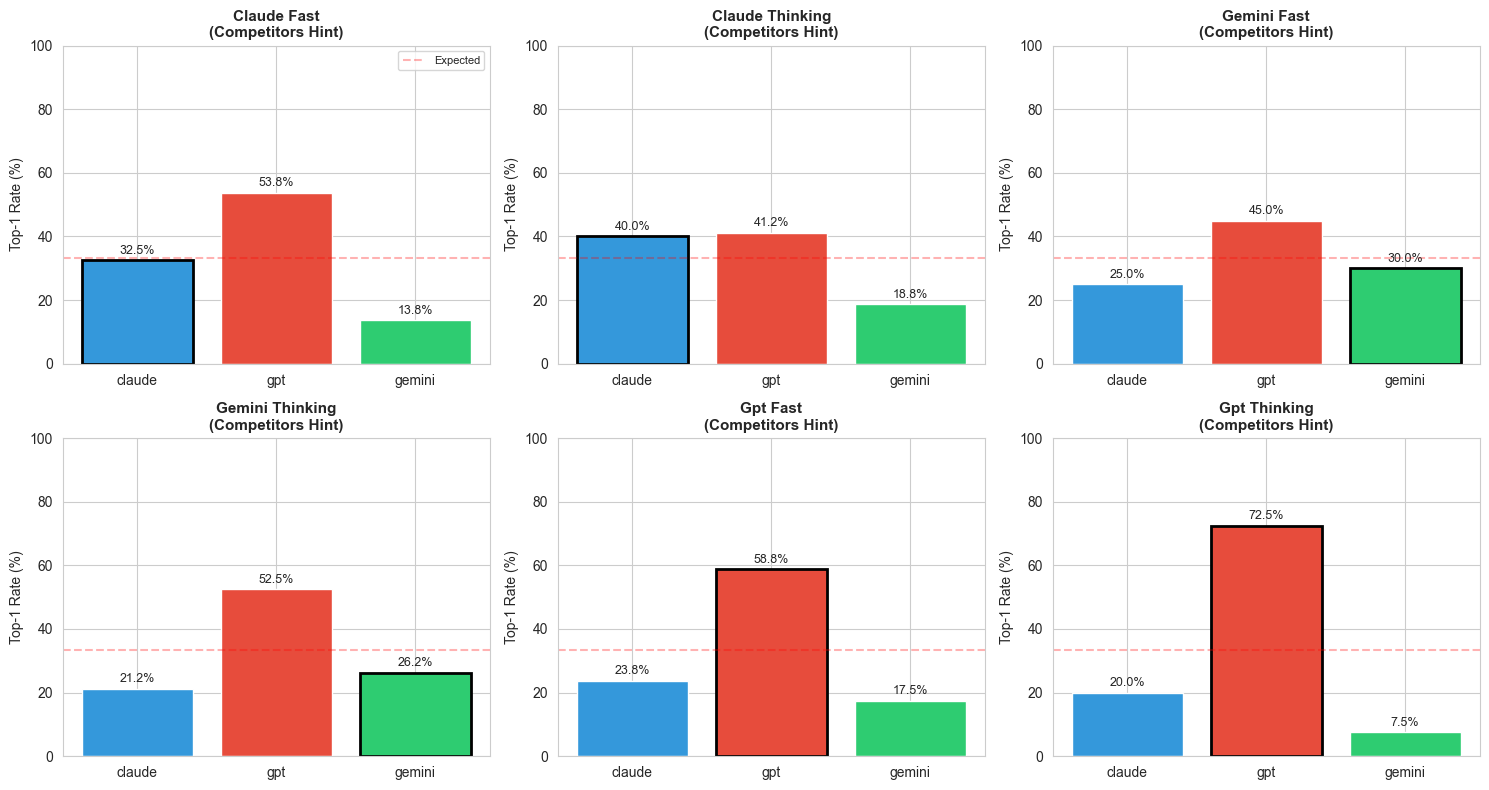

In [14]:
def calculate_vendor_preference_by_group(df, hint_group, judge=None):
    """Calculate top-1 preference rates for each vendor"""
    group_df = df[df['hint_group'] == hint_group]
    if judge:
        group_df = group_df[group_df['judge'] == judge]
    
    top1 = group_df[group_df['is_top_ranked'] == True]
    vendor_counts = top1.groupby('model_vendor').size()
    total = len(top1)
    
    results = []
    for vendor in ['claude', 'gpt', 'gemini']:
        count = vendor_counts.get(vendor, 0)
        percentage = (count / total * 100) if total > 0 else 0
        results.append({
            'vendor': vendor,
            'top1_percentage': percentage,
            'top1_count': count,
            'total': total
        })
    
    return pd.DataFrame(results)

# Compare judges for Group 2
judges = sorted(df_all[df_all['hint_group'] == 'group2_competitors']['judge'].unique())
n_judges = len(judges)
n_cols = 3
n_rows = (n_judges + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, judge in enumerate(judges):
    ax = axes[i]
    
    prefs = calculate_vendor_preference_by_group(df_all, 'group2_competitors', judge)
    
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    bars = ax.bar(prefs['vendor'], prefs['top1_percentage'], color=colors)
    
    # Highlight judge's own vendor
    judge_vendor = judge.split('_')[0]
    if judge_vendor in prefs['vendor'].values:
        idx = prefs[prefs['vendor'] == judge_vendor].index[0]
        bars[idx].set_edgecolor('black')
        bars[idx].set_linewidth(2)
    
    ax.set_title(f'{judge.replace("_", " ").title()}\n(Competitors Hint)', 
                fontsize=11, fontweight='bold')
    ax.set_ylabel('Top-1 Rate (%)', fontsize=10)
    ax.set_ylim([0, 100])
    ax.axhline(y=33.33, color='red', linestyle='--', alpha=0.3, label='Expected')
    if i == 0:
        ax.legend(fontsize=8)
    
    for k, (vendor, pct) in enumerate(zip(prefs['vendor'], prefs['top1_percentage'])):
        ax.text(k, pct + 2, f'{pct:.1f}%', ha='center', fontsize=9)

# Hide unused subplots
for i in range(n_judges, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('data/results/cross_judge_comparison_group2.png', dpi=300, bbox_inches='tight')
plt.show()


## 5. Statistical Tests: Does Competitors Hint Affect Self-Bias?

Test if Group 2 (Competitors) significantly differs from baseline (if available).


In [15]:
if 'group4_blind' in df_all['hint_group'].unique():
    def test_hinting_effect(df, vendor='gpt', baseline_group='group4_blind', target_group='group2_competitors'):
        """Statistical test comparing target group to baseline"""
        vendor_bias = calculate_self_bias_by_group(df, vendor)
        vendor_own = vendor_bias[vendor_bias['is_own_judge'] == True]
        
        # Get baseline rates (per judge)
        baseline = vendor_own[vendor_own['hint_group'] == baseline_group]
        baseline_rates = baseline['top1_rate'].values
        
        # Get target group rates
        target = vendor_own[vendor_own['hint_group'] == target_group]
        target_rates = target['top1_rate'].values
        
        if len(baseline_rates) > 0 and len(target_rates) > 0:
            # Paired t-test (same judges across conditions)
            if len(baseline_rates) == len(target_rates):
                t_stat, p_value = stats.ttest_rel(baseline_rates, target_rates)
                test_type = 'paired t-test'
            else:
                # Independent t-test if different sample sizes
                t_stat, p_value = stats.ttest_ind(baseline_rates, target_rates)
                test_type = 'independent t-test'
            
            mean_baseline = baseline_rates.mean() * 100
            mean_target = target_rates.mean() * 100
            change = mean_target - mean_baseline
            
            return {
                'vendor': vendor,
                'baseline_mean': mean_baseline,
                'group2_mean': mean_target,
                'change_pp': change,
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'test_type': test_type
            }
        return None
    
    # Test for all vendors
    stat_tests = []
    for vendor in ['claude', 'gpt', 'gemini']:
        result = test_hinting_effect(df_all, vendor)
        if result:
            stat_tests.append(result)
    
    stat_df = pd.DataFrame(stat_tests)
    
    print("Statistical Tests: Group 2 (Competitors) vs Group 4 (Blind)")
    print("=" * 80)
    print(stat_df[['vendor', 'baseline_mean', 'group2_mean', 'change_pp', 
                   'p_value', 'significant', 'test_type']].to_string(index=False))
    
    print("\nInterpretation:")
    for _, row in stat_df.iterrows():
        sig_str = "✓ Significant" if row['significant'] else "Not significant"
        change_str = f"+{row['change_pp']:.1f}" if row['change_pp'] >= 0 else f"{row['change_pp']:.1f}"
        print(f"  {row['vendor'].upper()}: {change_str} pp change, p={row['p_value']:.4f} ({sig_str})")
else:
    print("⚠ Group 4 (Blind) baseline not available for statistical comparison.")
    print("  Run with group4_blind.json to enable statistical tests.")


Statistical Tests: Group 2 (Competitors) vs Group 4 (Blind)
vendor  baseline_mean  group2_mean  change_pp  p_value  significant     test_type
claude         30.000       36.250       6.25 0.125666        False paired t-test
   gpt         64.375       65.625       1.25 0.500000        False paired t-test
gemini         33.125       28.125      -5.00 0.000000         True paired t-test

Interpretation:
  CLAUDE: +6.3 pp change, p=0.1257 (Not significant)
  GPT: +1.2 pp change, p=0.5000 (Not significant)
  GEMINI: -5.0 pp change, p=0.0000 (✓ Significant)


/opt/anaconda3/envs/DL/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


## 6. Summary Table: Self-Bias for Group 2

Create a summary table for Group 2 (Competitors) analysis.


In [16]:
# Create summary table for Group 2
summary_rows = []
for vendor in ['claude', 'gpt', 'gemini']:
    vendor_bias = calculate_self_bias_by_group(df_all, vendor)
    vendor_own = vendor_bias[(vendor_bias['is_own_judge'] == True) & 
                            (vendor_bias['hint_group'] == 'group2_competitors')]
    
    if len(vendor_own) > 0:
        mean_rate = vendor_own['top1_rate'].mean() * 100
        std_rate = vendor_own['top1_rate'].std() * 100
        n_judges = len(vendor_own)
        
        summary_rows.append({
            'Vendor': vendor.upper(),
            'Hint Group': 'Group 2 (Competitors)',
            'Self-Preference (%)': f'{mean_rate:.1f} ± {std_rate:.1f}',
            'N Judges': n_judges
        })

summary_df = pd.DataFrame(summary_rows)
print("Self-Bias Summary: Group 2 (Competitors)")
print("=" * 70)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv('data/results/self_bias_summary_group2.csv', index=False)
print("\n✓ Saved to data/results/self_bias_summary_group2.csv")


Self-Bias Summary: Group 2 (Competitors)
Vendor            Hint Group Self-Preference (%)  N Judges
CLAUDE Group 2 (Competitors)          36.3 ± 5.3         2
   GPT Group 2 (Competitors)          65.6 ± 9.7         2
GEMINI Group 2 (Competitors)          28.1 ± 2.7         2

✓ Saved to data/results/self_bias_summary_group2.csv


## 7. Key Findings

### Hypothesis for Group 2 (Competitors):
**Competitor-hint reduces self-bias**: Knowing competitors but not self leads to fairer evaluation

### Interpretation:
- **Self-preference rate**: Percentage of times a judge ranks their own vendor #1
- **Expected rate**: 33.3% (if completely unbiased)
- **Change from baseline (pp)**: Percentage point difference from blind condition
- **p < 0.05**: Statistically significant difference from baseline

### Next Steps:
- Run Group 1 (Self) to test if revealing own model increases bias
- Run Group 3 (Full) to test full transparency effect
- Compare all groups to understand complete hinting effect
